**Tech Challenge: exportação de vinhos**

Integrantes: Jackson, Haendel e Gabriel Oliveira

Entrega: 05/07/2023

# Dataset de vinhos

[Link para download do csv](http://vitibrasil.cnpuv.embrapa.br/download/ExpVinho.csv)

## Leitura dos dados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import numpy as np
import locale

pd.options.display.float_format = "{:.2f}".format

In [ ]:
wine_data = pd.read_csv('./data/raw/ExpVinho.csv', sep=';')
wine_data.drop(columns=['Id'], inplace=True)
wine_data.rename(columns={'País':'pais_destino'}, inplace=True)

In [ ]:
wine_data.head()

In [ ]:
wine_data.info()

In [ ]:
wine_data.isna().sum().sum()

## Processamento e limpeza

### pd.melt()

In [ ]:
wine_melted = pd.melt(wine_data, id_vars='pais_destino')
wine_melted.head()

### Criando variável 'ano'

In [ ]:
wine_melted['ano'] = wine_melted['variable'].astype(str).str[:4].astype('datetime64').dt.year
wine_melted.head()

In [ ]:
wine_melted.info()

### Criação de dfs contendo as linhas de cada variável numérica

In [ ]:
wine_melted.loc[wine_melted.variable.str.len() == 4]

In [ ]:
# DF para linhas com informação de litros exportados
melted_litros = wine_melted.loc[wine_melted.variable.str.len() == 4]
melted_litros.rename(columns={'value':'litros_exportados'}, inplace=True)
melted_litros = melted_litros[['pais_destino','ano','litros_exportados']]

In [ ]:
melted_litros.head()

In [ ]:
# DF para linhas com informação de valor exportado (US$)
melted_valor = wine_melted.loc[wine_melted.variable.str.len() == 6]
melted_valor.rename(columns={'value':'valor_exportacao'}, inplace=True)
melted_valor = melted_valor[['pais_destino','ano','valor_exportacao']]
display(melted_valor.head())

### Merge dos dois DFs em um único DataFrame

In [ ]:
df_wine_por_ano = melted_litros.merge(melted_valor, on=['pais_destino','ano'])
df_wine_por_ano.head(10)

### Filtragem dos anos de interesse (últimos 15)

In [ ]:
list_15_anos = list(df_wine_por_ano.ano.unique())[-15:]
print(list_15_anos)

In [ ]:
df_wine_por_ano_15_anos = df_wine_por_ano.query('ano in @list_15_anos').reset_index(drop=True)
df_wine_por_ano_15_anos.head()

### Cálculo do montante exportado por país nos últimos 15 anos

In [ ]:
df_wine_15_anos_soma = df_wine_por_ano_15_anos[['pais_destino',	'litros_exportados', 'valor_exportacao']].groupby('pais_destino').sum().reset_index()
df_wine_15_anos_soma

In [ ]:
# Ordenando por litros exportados
df_wine_15_anos_soma.sort_values(by='litros_exportados', ascending=False, inplace=True)
df_wine_15_anos_soma.reset_index(drop=True, inplace=True)
df_wine_15_anos_soma.head(15)

In [ ]:
#Criação
df_wine_15_anos_soma['pais_origem'] = 'Brasil'
df_wine_15_anos_soma = df_wine_15_anos_soma[['pais_origem','pais_destino','litros_exportados','valor_exportacao']]
df_wine_15_anos_soma.head()

# Dataset de dados climáticos: usando Climate API WorldBank (on hold, está fora do ar)

Nesta análise será explorada a relação entre o **consumo de vinhos** e o clima de cada país, mais precisamente as **temperaturas mínimas, médias e máximas anuais**. Desta forma, podem ser encontradas correlações interessantes entre climas mais frios e um maior consumo da bebida.

Claro que outros fatores demográficos e economicos também são relevantes para esse tipo de estudo, por isso a questão climática será abordada de maneira complementar a estas outras informações

Dataset usado: [Climate API](https://datahelpdesk.worldbank.org/knowledgebase/articles/889386-developer-information-overview)

Como usar: [Artigo no HatariLabs](https://hatarilabs.com/ih-en/how-to-download-climate-change-data-from-the-world-bank-data-api-with-python)

In [ ]:
!pip install wbpy
import wbpy
from pprint import pprint

In [ ]:
c_api = wbpy.ClimateAPI()

In [ ]:
c_api.ARG_DEFINITIONS

Para extrair os dados dos países de interesse, precisaremos dos códigos ISO 3166-1 de cada país, que funciona como um código de identificação padronizado globalmente

## Códigos ISO 3166-1

Fonte: https://pt.wikipedia.org/wiki/ISO_3166-1

In [ ]:
url_iso = 'https://pt.wikipedia.org/wiki/ISO_3166-1'
pd_iso = pd.read_html(url_iso)

In [ ]:
# Retornou uma lista de dataframes, porque há mais de uma tabela no link. Vamos usar a primeira tabela da url
type(pd_iso)

In [ ]:
pd_iso = pd_iso[0]
pd_iso.head()

In [ ]:
wine_df_15_anos_iso = df_wine_15_anos_soma.merge(pd_iso, left_on='pais_destino', right_on='País')

In [ ]:
wine_df_15_anos_iso

Não foi possível obter o codigo ISO para todos os países, pois existem diferenças nas nomenclaturas dos países entre os DFs.

### Padronização nome dos países

In [ ]:
# Criação de lista com países do df de vinhos que precisam de correção no nome
list_nome_paises_correcao_wine = [nome_pais for nome_pais in list(df_wine_15_anos_soma.pais_destino) if nome_pais not in list(wine_df_15_anos_iso.pais_destino)]

In [ ]:
list_nome_paises_correcao_wine

In [ ]:
# Novos nomes dos países
list_novos_nomes_paises = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Taiwan','Singapura','Guiné Equatorial','Benim','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul','Trinidad e Tobago','Barein','República Dominicana','Eslováquia','Congo','Namíbia','Ilhas Cayman','Ilha de Man','Índia','Guiné-Bissau','Bósnia-Herzegovina','Nicarágua','Suazilândia',
                           'Belize','Bangladesh','Ilhas Virgens','Anguilla']

In [ ]:
# Criação de  dicionário para mudança dos nomes
dict_rename_paises_wine = dict(zip(list_nome_paises_correcao_wine, list_novos_nomes_paises))
dict_rename_paises_wine

In [ ]:
# Criação de lista com países do df de codigo ISO que precisam de correção no nome
list_nome_paises_correcao_iso = ['Países Baixos (Holanda)','Reino Unido da Grã-Bretanha e Irlanda do Norte','Alemanha','Chéquia','Curaçau','Antilhas Holandesas','Estónia','Nova Zelândia (Aotearoa)','Emirados Árabes Unidos',
                                  'Coreia do Sul','Trindade e Tobago','Barém','Dominicana, República','Congo, República do','Caimã, Ilhas', 'Man, Ilha de','Bósnia e Herzegovina','Bangladexe', 'Virgens Americanas, Ilhas']

list_novos_nomes_paises_iso = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul', 'Trinidad e Tobago','Barein','República Dominicana','Congo','Ilhas Cayman','Ilha de Man','Bósnia-Herzegovina','Bangladesh','Ilhas Virgens']

# Criação de  dicionário para mudança dos nomes no df ISO
dict_rename_paises_iso = dict(zip(list_nome_paises_correcao_iso, list_novos_nomes_paises_iso))

In [ ]:
dict_rename_paises_iso

In [ ]:
# Novo df ISO com nomes dos países corrigidos
df_iso_renamed = pd_iso.replace({'País':dict_rename_paises_iso})
df_iso_renamed

In [ ]:
# Novo df de vinhos com nomes dos países corrigidos
wine_df_15_anos_renamed = df_wine_15_anos_soma.replace({'pais_destino':dict_rename_paises_wine})
display(wine_df_15_anos_renamed)

df_wine_por_ano_renamed = df_wine_por_ano.replace({'pais_destino':dict_rename_paises_wine})
display(df_wine_por_ano_renamed)

In [ ]:
# Merge final dos dois DFs para obter o codigo ISO de cada país do DF de vinhos
wine_df_15_anos_iso = wine_df_15_anos_renamed.merge(df_iso_renamed[['País','núm','alfa-3']], left_on='pais_destino', right_on='País', how='left')
wine_df_15_anos_iso.drop(columns=['País'], inplace=True)
wine_df_15_anos_iso.rename(columns={'núm':'iso_num', 'alfa-3':'iso_cod'}, inplace=True)
display(wine_df_15_anos_iso)

wine_df_por_ano_iso = df_wine_por_ano_renamed.merge(df_iso_renamed[['País','núm','alfa-3']], left_on='pais_destino', right_on='País', how='left')
wine_df_por_ano_iso.drop(columns=['País'], inplace=True)
wine_df_por_ano_iso.rename(columns={'núm':'iso_num', 'alfa-3':'iso_cod'}, inplace=True)
display(wine_df_por_ano_iso)

In [ ]:
# Países que continuaram sem código ISO, são territórios que não possuem código ISO próprio
wine_df_15_anos_iso.loc[wine_df_15_anos_iso.iso_cod.isna()]

In [2]:
#wine_df_15_anos_iso.to_csv('./data/processed/wine_data_15_years.csv', index=False)
wine_df_15_anos_iso = pd.read_csv('./data/processed/wine_data_15_years.csv')

#wine_df_por_ano_iso.to_csv('./data/processed/wine_data_by_year.csv', index=False)
wine_df_por_ano_iso = pd.read_csv('./data/processed/wine_data_by_year.csv')

# Dataset de dados climáticos: usando dado acumulado (Mitchell et al., 2003)

Nesta análise será explorada a relação entre o **consumo de vinhos** e o clima de cada país, mais precisamente as **temperaturas mínimas, médias e máximas anuais**. Desta forma, podem ser encontradas correlações interessantes entre climas mais frios e um maior consumo da bebida.

Claro que outros fatores demográficos e economicos também são relevantes para esse tipo de estudo, por isso a questão climática será abordada de maneira complementar a estas outras informações

Dataset usado: [Mitchell et al. 2003](https://web.archive.org/web/20150905135247/http://lebanese-economy-forum.com/wdi-gdf-advanced-data-display/show/EN-CLC-AVRT-C/)

Link Wikipédia: https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature

## Leitura dataset temperatura média

In [ ]:
url_climate_wiki = 'https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature'

df_climate_wiki = pd.read_html(url_climate_wiki)

In [ ]:
# Retornou uma lista, deve-se usar a primeira tabela da página
type(df_climate_wiki)

In [ ]:
df_climate_wiki = df_climate_wiki[0]

In [ ]:
df_climate_wiki

## Códigos dos países com nome em inglês

In [ ]:
df_iso_codes_en = pd.read_html('https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes')
df_iso_codes_en = df_iso_codes_en[0]
display(df_iso_codes_en)

In [ ]:
df_iso_codes_en.columns = [col[1] for col in df_iso_codes_en.columns]

In [ ]:
df_climate_wiki_iso = df_climate_wiki.merge(df_iso_codes_en[['Country name[5]', 'Alpha-3 code[5]',	'Numeric code[5]']], left_on='Country', right_on='Country name[5]', how='left')

### Ajuste dos nomes dos paises para fazer o merge

In [ ]:
new_names_iso_codes_en = list(df_climate_wiki_iso.loc[df_climate_wiki_iso['Country name[5]'].isna()].Country)
new_names_iso_codes_en.sort()
print(new_names_iso_codes_en)

In [ ]:
list_countries_merged = list(df_climate_wiki_iso.loc[df_climate_wiki_iso['Country name[5]'].isna() == False]['Country name[5]'])

In [ ]:
df_iso_codes_en

In [ ]:
list_countries_not_merged = [country for country in df_iso_codes_en['Country name[5]'] if country not in list_countries_merged]
print(list_countries_not_merged)

In [ ]:
"""['Australia', 'Bahamas', 'Bolivia', 'Brunei', 'Cape Verde', 'Central African Republic', 'Comoros', 'Czech Republic', 'Democratic Republic of the Congo',
 'Denmark [note 2]', 'Dominican Republic', 'Eswatini', 'Federated States of Micronesia', 'France', 'Gambia', 'Iran', 'Ivory Coast', 'Laos', 'Marshall Islands',
 'Moldova', 'Myanmar', 'Netherlands', 'Niger', 'North Korea', 'North Macedonia', 'Norway [note 1]', 'Philippines', 'Republic of the Congo', 'Russia', 'South Korea',
 'Sudan', 'Syria', 'São Tomé and Príncipe', 'Tanzania', 'Timor-Leste', 'Turkey', 'United Arab Emirates', 'United Kingdom', 'United States', 'Venezuela', 'Vietnam']"""


list_countries_to_rename_iso_en = ['Australia\u200a[c]', 'Bahamas (the)', 'Bolivia (Plurinational State of)', 'Brunei Darussalam\u200a[f]', 'Cabo Verde\u200a[g]', 'Central African Republic (the)', 'Comoros (the)', 'Czechia\u200a[j]',
                                   'Congo (the Democratic Republic of the)', 'Denmark','Dominican Republic (the)',  'Eswatini\u200a[k]', 'Micronesia (Federated States of)', 'France\u200a[m]',
                                   'Gambia (the)', 'Iran (Islamic Republic of)', "Côte d'Ivoire\u200a[i]", "Lao People's Democratic Republic (the)\u200a[r]",'Marshall Islands (the)','Moldova (the Republic of)','Myanmar\u200a[u]',
                                   'Netherlands, Kingdom of the','Niger (the)', "Korea (the Democratic People's Republic of)\u200a[p]",'North Macedonia\u200a[t]','Norway','Philippines (the)','Republic of the Congo – See Congo, The.',
                                   'Russian Federation (the)\u200a[w]', 'Korea (the Republic of)\u200a[q]','Sudan (the)', 'Syrian Arab Republic (the)\u200a[y]', 'Sao Tome and Principe', 'Tanzania, the United Republic of',
                                   'Timor-Leste\u200a[ab]', 'Türkiye [ac]', 'United Arab Emirates (the)','United Kingdom of Great Britain and Northern Ireland (the)','United States of America (the)','Venezuela (Bolivarian Republic of)', 'Viet Nam\u200a[ag]']

In [ ]:
# Criação de  dicionário para mudança dos nomes no df ISO em Inglês
dict_rename_paises_iso_en = dict(zip(list_countries_to_rename_iso_en, new_names_iso_codes_en))

In [ ]:
# Novo df ISO com nomes dos países corrigidos
df_iso_codes_en_renamed = df_iso_codes_en.replace({'Country name[5]':dict_rename_paises_iso_en})
df_iso_codes_en_renamed

### Merge entre df de temperatura e codigos ISO

In [ ]:
df_climate_wiki_iso = df_climate_wiki.merge(df_iso_codes_en_renamed[['Country name[5]', 'Alpha-3 code[5]',	'Numeric code[5]']], left_on='Country', right_on='Country name[5]', how='left')

In [ ]:
df_climate_wiki_iso

In [ ]:
df_climate_wiki_iso.rename(columns={'Country name[5]':'country','Alpha-3 code[5]':'iso_cod',	'Numeric code[5]':'iso_num', 'Average yearly temperature (1961–1990 Celsius)':'temp_anual_media'}, inplace=True)
df_climate_wiki_iso

### Merge do DF de vinhos com DF de isocode

In [ ]:
url_iso = 'https://pt.wikipedia.org/wiki/ISO_3166-1'
df_iso_pt = pd.read_html(url_iso)

In [ ]:
# Retornou uma lista de dataframes, porque há mais de uma tabela no link. Vamos usar a primeira tabela da url
type(df_iso_pt)

df_iso_pt = df_iso_pt[0]
display(df_iso_pt.head())

In [ ]:
df_wine_15_anos_iso = df_wine_15_anos_soma.merge(df_iso_pt, left_on='pais_destino', right_on='País', how='left')
print('Total de países em que o merge não foi feito:', df_wine_15_anos_iso['País'].isna().sum())
display(df_wine_15_anos_iso)

A nomenclatura dos países está fora do padrão, por isso nem todas as linhas do dataframe foram mergeadas

In [ ]:
# Criação de lista com países do df de vinhos que precisam de correção no nome
list_nome_paises_correcao_wine = [nome_pais for nome_pais in list(df_wine_15_anos_soma.pais_destino) if nome_pais not in list(df_wine_15_anos_iso['País'])]

print(list_nome_paises_correcao_wine)

In [ ]:
# Novos nomes dos países
list_novos_nomes_paises = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Taiwan','Singapura','Guiné Equatorial','Benim','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul','Trinidad e Tobago','Barein','República Dominicana','Eslováquia','Congo','Namíbia','Ilhas Cayman','Ilha de Man','Índia','Guiné-Bissau','Bósnia-Herzegovina','Nicarágua','Suazilândia',
                           'Belize','Bangladesh','Ilhas Virgens','Anguilla']

In [ ]:
# Criação de  dicionário para mudança dos nomes
dict_rename_paises_wine = dict(zip(list_nome_paises_correcao_wine, list_novos_nomes_paises))
print(dict_rename_paises_wine)

In [ ]:
# Criação de lista com países do df de codigo ISO que precisam de correção no nome
list_nome_paises_correcao_iso = ['Países Baixos (Holanda)','Reino Unido da Grã-Bretanha e Irlanda do Norte','Alemanha','Chéquia','Curaçau','Antilhas Holandesas','Estónia','Nova Zelândia (Aotearoa)','Emirados Árabes Unidos',
                                  'Coreia do Sul','Trindade e Tobago','Barém','Dominicana, República','Congo, República do','Caimã, Ilhas', 'Man, Ilha de','Bósnia e Herzegovina','Bangladexe', 'Virgens Americanas, Ilhas']

list_novos_nomes_paises_iso = ['Países Baixos','Reino Unido','Alemanha','República Tcheca','Curaçao','Antilhas Holandesas','Estônia','Nova Zelândia','Emirados Árabes Unidos',
                           'Coréia do Sul', 'Trinidad e Tobago','Barein','República Dominicana','Congo','Ilhas Cayman','Ilha de Man','Bósnia-Herzegovina','Bangladesh','Ilhas Virgens']

# Criação de  dicionário para mudança dos nomes no df ISO
dict_rename_paises_iso = dict(zip(list_nome_paises_correcao_iso, list_novos_nomes_paises_iso))
print(dict_rename_paises_iso)

In [ ]:
# Novo df ISO com nomes dos países corrigidos
df_iso_pt_renamed = df_iso_pt.replace({'País':dict_rename_paises_iso})
df_iso_pt_renamed

In [ ]:
# Novo df de vinhos com nomes dos países corrigidos
df_wine_15_anos_soma_renamed = df_wine_15_anos_soma.replace({'pais_destino':dict_rename_paises_wine})
df_wine_15_anos_soma_renamed

In [ ]:
# Merge final dos dois DFs para obter o codigo ISO de cada país do DF de vinhos
df_wine_15_anos_iso = df_wine_15_anos_soma_renamed.merge(df_iso_pt_renamed[['País','núm','alfa-3']], left_on='pais_destino', right_on='País', how='left')
df_wine_15_anos_iso.drop(columns=['País'], inplace=True)
df_wine_15_anos_iso.rename(columns={'núm':'iso_num', 'alfa-3':'iso_cod'}, inplace=True)

print('Total de países em que o merge não foi feito:', df_wine_15_anos_iso['iso_cod'].isna().sum())
display(df_wine_15_anos_iso)

In [ ]:
# Países que continuaram sem código ISO, são territórios que não possuem código ISO próprio
df_wine_15_anos_iso.loc[df_wine_15_anos_iso.iso_cod.isna()]

# Merge dataset de vinhos com dados climáticos

In [ ]:
df_wine_15_anos_iso

In [ ]:
df_wine_15_anos_temperature = df_wine_15_anos_iso.merge(df_climate_wiki_iso[['iso_cod','temp_anual_media']], on='iso_cod', how='left')
print(df_wine_15_anos_temperature.dtypes)
display(df_wine_15_anos_temperature)

In [ ]:
# Coluna de temperatura está como tipo object, ou seja, não está sendo intepretada como uma coluna numérica. Para alterar isso será necessário aplicar um replace no caracter '−' por '-', desta forma os números negativos serão corretamente interpretados
df_wine_15_anos_temperature.temp_anual_media = df_wine_15_anos_temperature.temp_anual_media.str.replace('−','-')
df_wine_15_anos_temperature.temp_anual_media=  df_wine_15_anos_temperature.temp_anual_media.astype(float)
print(df_wine_15_anos_temperature.dtypes)

In [ ]:
# Alguns países estão sem dados de temperatura, por questões territoriais não são considerados países efetivamente de acordo com alguns critérios
print('Total de países em que o merge não foi feito:', df_wine_15_anos_temperature['temp_anual_media'].isna().sum())
df_wine_15_anos_temperature.loc[df_wine_15_anos_temperature.temp_anual_media.isna()]

## Adição das temperaturas de países/terriórios faltantes

In [ ]:
# Criação de lista com nome dos países sem dado de temperatura média
list_countries_no_temperature = list(df_wine_15_anos_temperature.loc[df_wine_15_anos_temperature.temp_anual_media.isna()].pais_destino)
print(list_countries_no_temperature)

# Lista com valores de temperatura anual média obtida na web via ChatGPT
list_temperatures = [28,28,24, 26, 28, 19, 25, 28, 11, 25, 19, 28, 27, 26]

In [ ]:
# Criação de  dicionário para atualizar os valores de temperatura
dict_add_temperature_values = dict(zip(list_countries_no_temperature, list_temperatures))
print(dict_add_temperature_values)

In [ ]:
df_wine_15_anos_temperature.loc[df_wine_15_anos_temperature['pais_destino'].isin(dict_add_temperature_values.keys()), 'temp_anual_media'] = df_wine_15_anos_temperature['pais_destino'].map(dict_add_temperature_values)

print('Total de países com valor de temperatura nulo:', df_wine_15_anos_temperature['temp_anual_media'].isna().sum())
display(df_wine_15_anos_temperature)

In [ ]:
# Dataframe final contendo dados de exportação de vinhos e temperatura média anual dos paises de destino. Um dos DFs é dividido por 1 milhão para facilitar as análises
wine_data_temperature = df_wine_15_anos_temperature[['pais_origem','pais_destino','iso_cod','litros_exportados','valor_exportacao','temp_anual_media']]

wine_data_temperature_milhoes = df_wine_15_anos_temperature[['pais_origem','pais_destino','iso_cod','litros_exportados','valor_exportacao','temp_anual_media']]
wine_data_temperature_milhoes['litros_exportados'] =  wine_data_temperature_milhoes.litros_exportados/1_000_000
wine_data_temperature_milhoes['valor_exportacao'] =  wine_data_temperature_milhoes.valor_exportacao/1_000_000
wine_data_temperature_milhoes

In [3]:
# Exportando dataframe final com temperaturas
#wine_data_temperature.to_csv('./data/processed/wine_data_15_years.csv', index=False)
#wine_data_temperature_milhoes.to_csv('./data/processed/wine_data_15_years_millions.csv', index=False)

# Leitura dos dataframes exportados após conclusão do processamento
wine_data_temperature = pd.read_csv('./data/processed/wine_data_15_years.csv')
wine_data_temperature_milhoes = pd.read_csv('./data/processed/wine_data_15_years_millions.csv')

# Gráficos e exploração dos dados

In [4]:
wine_df_por_ano_iso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pais_destino       6448 non-null   object 
 1   ano                6448 non-null   int64  
 2   litros_exportados  6448 non-null   int64  
 3   valor_exportacao   6448 non-null   int64  
 4   iso_num            6292 non-null   float64
 5   iso_cod            6292 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 302.4+ KB


In [5]:
wine_data_temperature_milhoes.describe()

,litros_exportados,valor_exportacao,temp_anual_media
count,124.00,124.00,124.00
mean,0.68,0.85,19.22
std,4.19,3.84,8.44
min,0.00,0.00,-5.35
25%,0.00,0.00,11.41
50%,0.01,0.02,23.48
75%,0.08,0.21,25.71
max,39.23,32.36,28.00


## Estatísticas gerais

In [35]:
print('Total de países importadores de vinho brasileiro: '+str(len(wine_data_temperature_milhoes.query('litros_exportados > 0').pais_destino.unique()))+' países')

print('Total de vinho exportado em 15 anos: '+str(round(wine_data_temperature_milhoes.litros_exportados.sum(),2))+' milhões de litros')

print('Valor total de vinho exportado em 15 anos: U$'+str(round(wine_data_temperature_milhoes.valor_exportacao.sum(),2))+' milhões')

print('Média de litros exportados por país: '+str(round(wine_data_temperature.litros_exportados.mean(),2))+' litros')

print('Mediana de litros exportados por país: '+str(round(wine_data_temperature.litros_exportados.median(),2))+' litros')

Total de países importadores de vinho brasileiro: 113 países
Total de vinho exportado em 15 anos: 84.24 milhões de litros
Valor total de vinho exportado em 15 anos: U$105.39 milhões
Média de litros exportados por país: 679340.33 litros
Mediana de litros exportados por país: 7144.0 litros


## Distribuição

findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


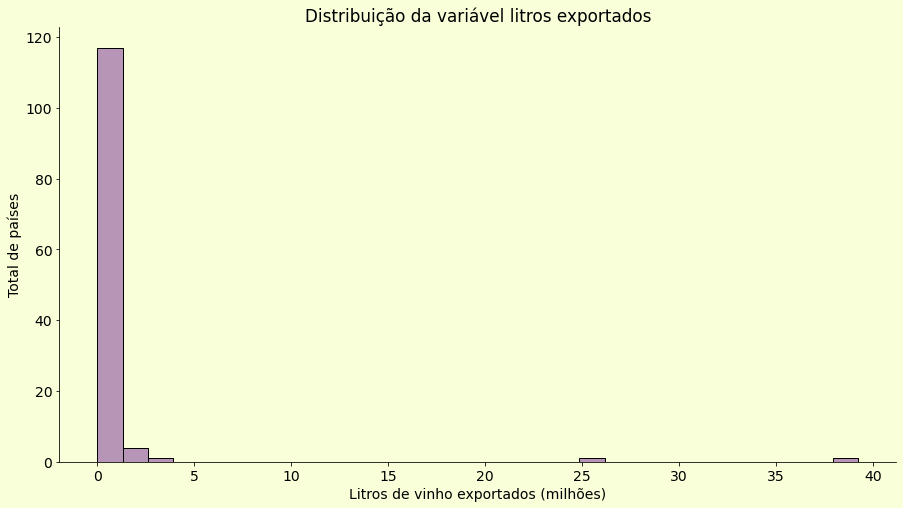

In [7]:
# Ajustando o tamanho da figura do gráfico.
g = plt.figure(figsize=(15,8))

# Definição do estilo
plt.style.use('./Assets/Estilos/barras.mplstyle')

ax = sns.histplot(wine_data_temperature_milhoes['litros_exportados'], bins = 30, color='#A272AB')

# Customização dos eixos e título
ax.set_title('Distribuição da variável litros exportados')
ax.set_xlabel('Litros de vinho exportados (milhões)')
ax.set_ylabel('Total de países')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')

# Altera a cor fora do gráfico
g.patch.set_facecolor('#F8FFD9')

plt.show()

É possível perceber que paísem com números baixíssimos de exportação estão poluindo a análise, sem agregar nenhuma informação relevante. Por isso, estes países serão filtrados da nossa base usando o limiar de no mínimo 10 mil litros exportados.

In [8]:
wine_data_temperature_filtered = wine_data_temperature_milhoes.query('litros_exportados > 0.01').reset_index(drop=True)
print(wine_data_temperature_filtered.shape)

(58, 6)


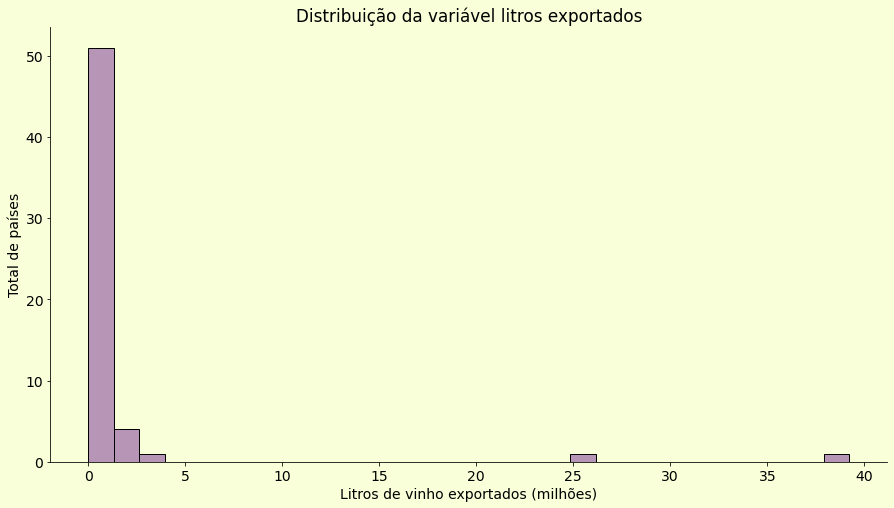

In [9]:
# Ajustando o tamanho da figura do gráfico.
g = plt.figure(figsize=(15,8))

# Definição do estilo
plt.style.use('./Assets/Estilos/barras.mplstyle')

ax = sns.histplot(wine_data_temperature_filtered['litros_exportados'], bins = 30, color='#A272AB')

# Customização dos eixos e título
ax.set_title('Distribuição da variável litros exportados')
ax.set_xlabel('Litros de vinho exportados (milhões)')
ax.set_ylabel('Total de países')
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')

# Altera a cor fora do gráfico
g.patch.set_facecolor('#F8FFD9')

plt.show()

filename = 'histograma_litros_exportados'
g.savefig('./results/'+filename+'.png')

Ainda assim, a distribuição da variável continua bastante assimétrica, indicando que o Brasil exporta baixas quantidades de vinho para a maioria dos países do mundo, porém possui grandes parceiros comerciais específicos.

## Litros exportados x Valor de exportação

Na maioria das vezes maiores quantidades de vinho exportadas representarão um maior valor de exportação. Porém, é também importante verificar o valor do litro exportado para cada país e com isso identificar para quais países a venda do Brasil é mais rentável ou então para onde estão indo os vinhos de maior qualidade.

In [10]:
# Aplicação do pd.melt() para facilitar construção de alguns tipos de gráficos como o gráfico de barras múltiplas
wine_data_melted = wine_data_temperature_milhoes.drop(columns=['pais_origem', 'iso_cod'])
wine_data_melted = pd.melt(wine_data_melted, id_vars='pais_destino')
wine_data_melted

,pais_destino,variable,value
0,Rússia,litros_exportados,39.23
1,Paraguai,litros_exportados,25.42
2,Estados Unidos,litros_exportados,3.82
3,China,litros_exportados,2.41
4,Espanha,litros_exportados,1.99
...,...,...,...
367,Senegal,temp_anual_media,27.85
368,Jamaica,temp_anual_media,24.95
369,Anguilla,temp_anual_media,26.00
370,Costa do Marfim,temp_anual_media,26.35


In [11]:
# Criação de lista com países top 10 em litros exportados
list_top_10 = list(wine_data_melted.pais_destino.unique()[:10])
print(list_top_10)

['Rússia', 'Paraguai', 'Estados Unidos', 'China', 'Espanha', 'Japão', 'Países Baixos', 'Reino Unido', 'Haiti', 'Alemanha']


findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Liberation Serif'] not found. Falling back to DejaVu Sans.


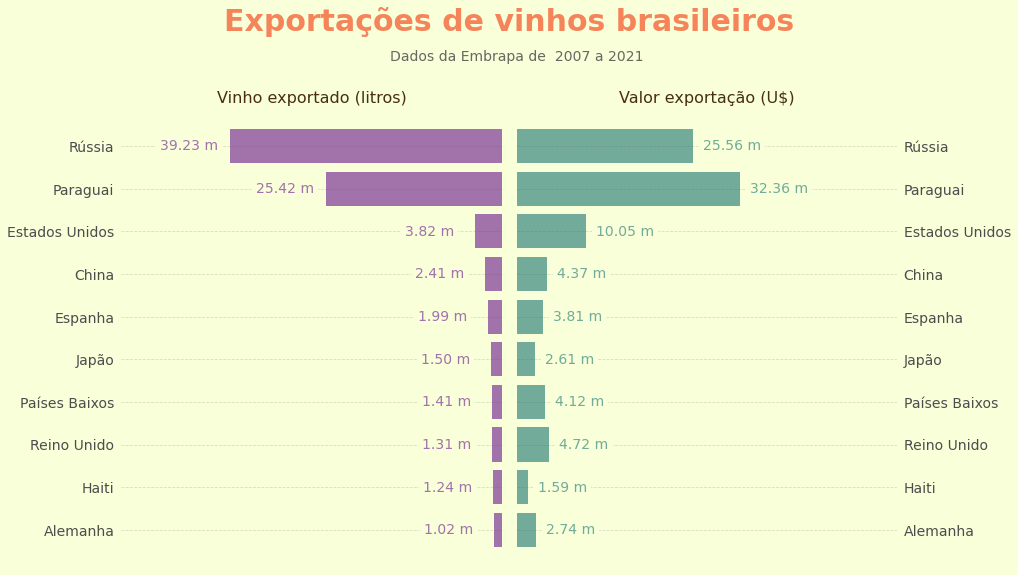

In [12]:
# Escolhe o tema/estilo do gráfico dentre os já criados na pasta Estilos
plt.style.use('./Assets/Estilos/bidirecional.mplstyle')

# Cria um sobplot par a figura
fig, ax = plt.subplots(figsize=(12,7), facecolor='#F8FFD9', ncols=2, sharey=True)

# Escolhe o layout tight para o gráfico
fig.tight_layout()

# Criando as barras horizontais para ambas colunas
ax[0].barh(wine_data_temperature_milhoes.query('pais_destino in @list_top_10')['pais_destino'], wine_data_temperature_milhoes.query('pais_destino in @list_top_10')['litros_exportados'], align='center', color='#A272AB', alpha=1)
ax[0].set_title('Vinho exportado (litros)', fontsize=16, weight='light', pad=5, color='#482E14')

ax[1].barh(wine_data_temperature_milhoes.query('pais_destino in @list_top_10')['pais_destino'], wine_data_temperature_milhoes.query('pais_destino in @list_top_10')['valor_exportacao'], align='center', color='#72AB99', alpha=1)
ax[1].set_title('Valor exportação (U$)', fontsize=16, weight='light', pad=5, color='#482E14')

# Invertendo e delimitando o eixo x dos valores de quantidade de litros de vinho exportado
ax[0].set_xlim(0,55)
ax[1].set_xlim(0,55)
ax[0].invert_xaxis() 

# Invertendo o eixo y do gráfico
plt.gca().invert_yaxis()

# Ajusta os números no final das barras do quantidade de litros de vinho
for i, c in enumerate(ax[0].containers):
    ax[0].bar_label(c, label_type='edge', fmt='%.2f m', padding=-70, color='#A272AB', bbox=dict(facecolor='#F8FFD9', edgecolor='none'))

# Ajusta os números no final das barras do quantidade de valor exportado
for i, c in enumerate(ax[1].containers):
    ax[1].bar_label(c, label_type='edge', fmt='%.2f m', padding=10, color='#72AB99', bbox=dict(facecolor='#F8FFD9', edgecolor='none'))

ax[0].grid(axis='y', color='#525252', alpha=0.2, linestyle='dashed')
ax[1].grid(axis='y', color='#525252', alpha=0.2, linestyle='dashed')

fig.suptitle('Exportações de vinhos brasileiros', size=30, weight='semibold', x=.5, y=1.16, color="#F5845B", ha='center', fontname='Liberation Serif')
plt.text(x=0, y=-2, s='Dados da Embrapa de  2007 a 2021', fontsize=14, alpha=0.85, color="#4d4d4d", ha='center')

# Altera a cor dentro do gráfico
ax[0].set_facecolor('#F8FFD9')
# Altera a cor dentro do gráfico
ax[1].set_facecolor('#F8FFD9')
# Altera a cor fora do gráfico
fig.patch.set_facecolor('#F8FFD9')

fig.savefig('./results/top10_litros_valor_exportacao_bidirecional.png', bbox_inches='tight')

plt.show()

Pegando os países Paraguai e Rússia como exemplo, vemos que nem sempre maiores valores de litros exportados significam maiores valores de exportação em U$, indicando que há variação no preço do litro do vinho exportado de acordo com o país destino.

Para propor estratégias futuras de exportação e entendermos o contexto atual do mercado é imprescindível avaliar como estes valores de exportação variaram ano a ano neste recorte de 15 anos.

## Evolução temporal

### Area chart: acumulao de vinho exportado nos ultimos 15 anos

In [13]:
import itertools

In [14]:
wine_df_por_ano_iso

,pais_destino,ano,litros_exportados,valor_exportacao,iso_num,iso_cod
0,Afeganistão,1970,0,0,4.00,AFG
1,África do Sul,1970,0,0,710.00,ZAF
2,Alemanha,1970,0,0,276.00,DEU
3,Angola,1970,0,0,24.00,AGO
4,Anguilla,1970,0,0,NaN,NaN
...,...,...,...,...,...,...
6443,Tuvalu,2021,0,0,798.00,TUV
6444,Uruguai,2021,136774,149842,858.00,URY
6445,Vanuatu,2021,0,0,548.00,VUT
6446,Venezuela,2021,26415,35944,862.00,VEN


In [15]:
wine_df_groupby_year = wine_df_por_ano_iso.groupby('ano')[['litros_exportados','valor_exportacao']].agg('sum').reset_index()
wine_df_groupby_year.head()

,ano,litros_exportados,valor_exportacao
0,1970,136009,40500
1,1971,281305,83465
2,1972,381020,121097
3,1973,471270,174792
4,1974,356985,185871


In [16]:
wine_df_groupby_year['litros_exportados_acc'] = list(itertools.accumulate(list(wine_df_groupby_year.litros_exportados.values)))
wine_df_groupby_year['valor_exportacao_acc'] = list(itertools.accumulate(list(wine_df_groupby_year.valor_exportacao.values)))
wine_df_groupby_year_milhoes = wine_df_groupby_year.copy()
wine_df_groupby_year_milhoes[['litros_exportados','valor_exportacao','litros_exportados_acc', 'valor_exportacao_acc']] = wine_df_groupby_year_milhoes[['litros_exportados','valor_exportacao','litros_exportados_acc', 'valor_exportacao_acc']]/1_000_000

wine_df_groupby_year.to_csv('./data/processed/wine_data_by_year_accumulate.csv', index=False)
wine_df_groupby_year_milhoes.to_csv('./data/processed/wine_data_by_year_accumulate_millions.csv', index=False)

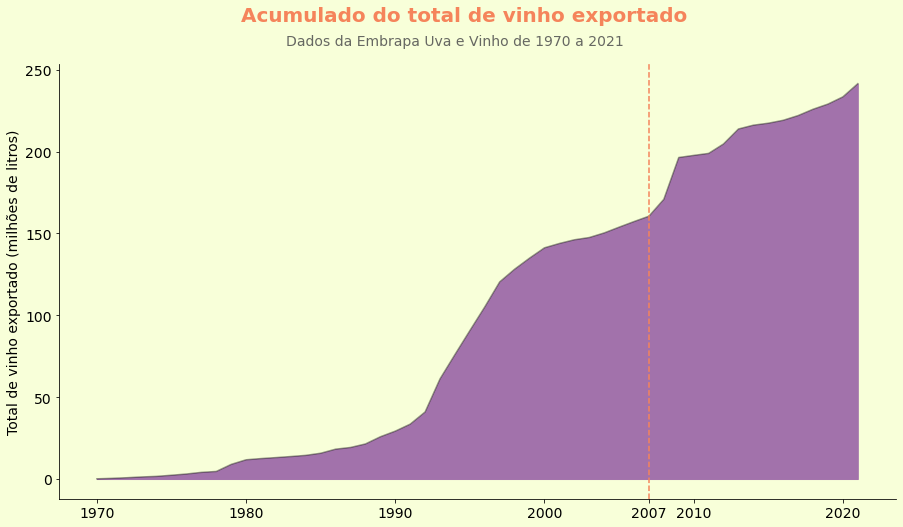

In [26]:
# Ajustando o tamanho da figura do gráfico.
fig = plt.figure(figsize=(15,8))

# Definição do estilo
plt.style.use('./Assets/Estilos/barras.mplstyle')

ax = fig.add_subplot()

ax.fill_between(wine_df_groupby_year_milhoes.ano, wine_df_groupby_year_milhoes.litros_exportados_acc, color='#A272AB')
ax.plot(wine_df_groupby_year_milhoes.ano, wine_df_groupby_year_milhoes.litros_exportados_acc, color="black", alpha=0.4)
ax.axvline(x=2007, linestyle='--', color='#F5845B')

ax.set_ylabel('Total de vinho exportado (milhões de litros)')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax.set_xticks([1970,1980,1990,2000,2007,2010,2020])

# Configuração do título e subtítulo
fig.suptitle('Acumulado do total de vinho exportado', size=20, weight='semibold', color="#F5845B", ha='center', fontname='Liberation Serif')
plt.text(x=1994, y=265, s='Dados da Embrapa Uva e Vinho de 1970 a 2021', fontsize=14, alpha=0.85, color="#4d4d4d", ha='center')

# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')

# Altera a cor fora do gráfico
fig.patch.set_facecolor('#F8FFD9')

plt.show()

filename = 'areaplot_exportacoes_ano_a_ano_acumulado'
fig.savefig('./results/'+filename+'.png')

### Timeseries: vinho exportado nos ultimos 15 anos nos 10 principais países

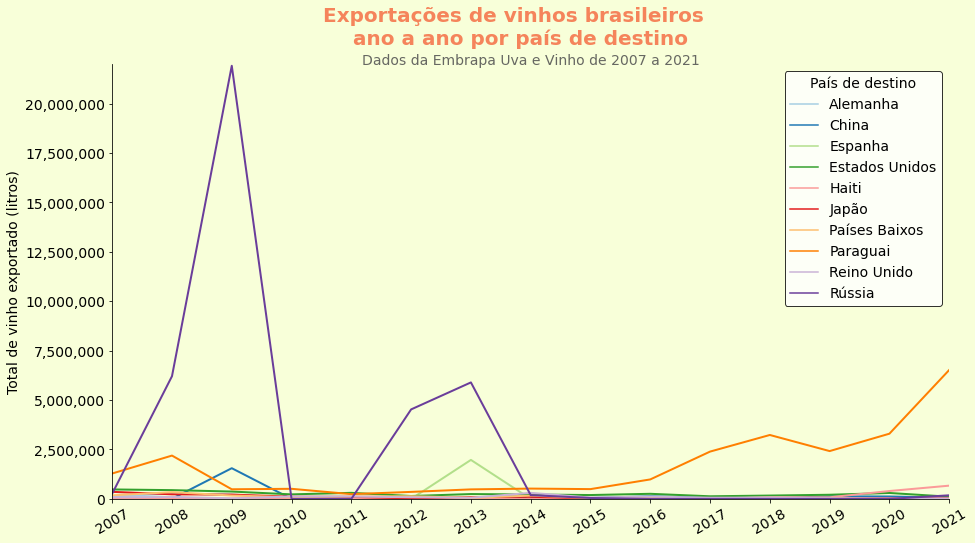

In [27]:
# Ajustando o tamanho da figura do gráfico.
fig = plt.figure(figsize=(15,8))

# Definição do estilo
plt.style.use('./Assets/Estilos/barras.mplstyle')

# Plot de linha
ax = sns.lineplot(data=wine_df_por_ano_iso.query('pais_destino in @list_top_10'), x='ano', y='litros_exportados', hue='pais_destino', palette='Paired', linewidth=2)

# Configuração dos eixos
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel('')
ax.set_ylabel('Total de vinho exportado (litros)')
ax.set_xlim(2007, 2021)
ax.set_ylim(-1000, 22000000)
ax.xaxis.set_major_locator(ticker.IndexLocator(base=1, offset=10))
plt.xticks(rotation=30)


# Configuração da legenda
legenda = plt.legend(title='País de destino')
legenda.get_frame().set_edgecolor('black')

# Configuração do título e subtítulo
fig.suptitle('Exportações de vinhos brasileiros \n ano a ano por país de destino', size=20, weight='semibold', color="#F5845B", ha='center', fontname='Liberation Serif')
plt.text(x=2014, y=22000000, s='Dados da Embrapa Uva e Vinho de 2007 a 2021', fontsize=14, alpha=0.85, color="#4d4d4d", ha='center')


# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')

# Altera a cor fora do gráfico
fig.patch.set_facecolor('#F8FFD9')

plt.show()

filename = 'top10_lineplot_exportacoes_ano_a_ano'
fig.savefig('./results/'+filename+'.png')

Com está análise da evolução temporal, percebe-se que, apesar da Rússia se manter como principal compradora de vinho brasileiro no acumulado dos últimos 15 anos, desde 2014 reduziu ocorreu uma queda abrupta nas importações de vinho brasileiro. É uma informação muito valiosa, porque indica uma possível mudança no padrão de consumo dos russos, que pode estar comprando vinho de outro país, ou então sugere que a relação comercial dos dois países foi prejudicada nos últimos anos. 

De qualquer forma, reatar as comercializações com esse país pode ser o **principal caminho** para aumentar as exportações de vinhos brasileiros.

## Preço do litro exportado

Outra estratégia possível para o futuro do mercado de vinhos brasileiros é o foco nas vendas de maior valor agregado, isto é, exportar vinho com maior valor médio do litro. 

Por isso, obter o preço médio do litro exportado para cada país é uma informação interessante para identificarmos as relações comerciais mais rentáveis ou então o destino dos vinhos mais valorizados.

In [19]:
# Criação da variável preco_litro
wine_data_temperature['preco_litro'] = wine_data_temperature.valor_exportacao / wine_data_temperature.litros_exportados
wine_data_temperature.query('litros_exportados > 0')

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro
0,Brasil,Rússia,RUS,39230153,25559026,-5.35,0.65
1,Brasil,Paraguai,PRY,25423559,32364257,23.55,1.27
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55,2.63
3,Brasil,China,CHN,2411701,4372268,7.50,1.81
4,Brasil,Espanha,ESP,1993000,3808552,13.30,1.91
...,...,...,...,...,...,...,...
109,Brasil,Belize,BLZ,9,29,25.35,3.22
110,Brasil,São Vicente e Granadinas,VCT,8,48,26.80,6.00
111,Brasil,Bangladesh,BGD,5,49,25.00,9.80
112,Brasil,Indonésia,IDN,5,6,25.85,1.20


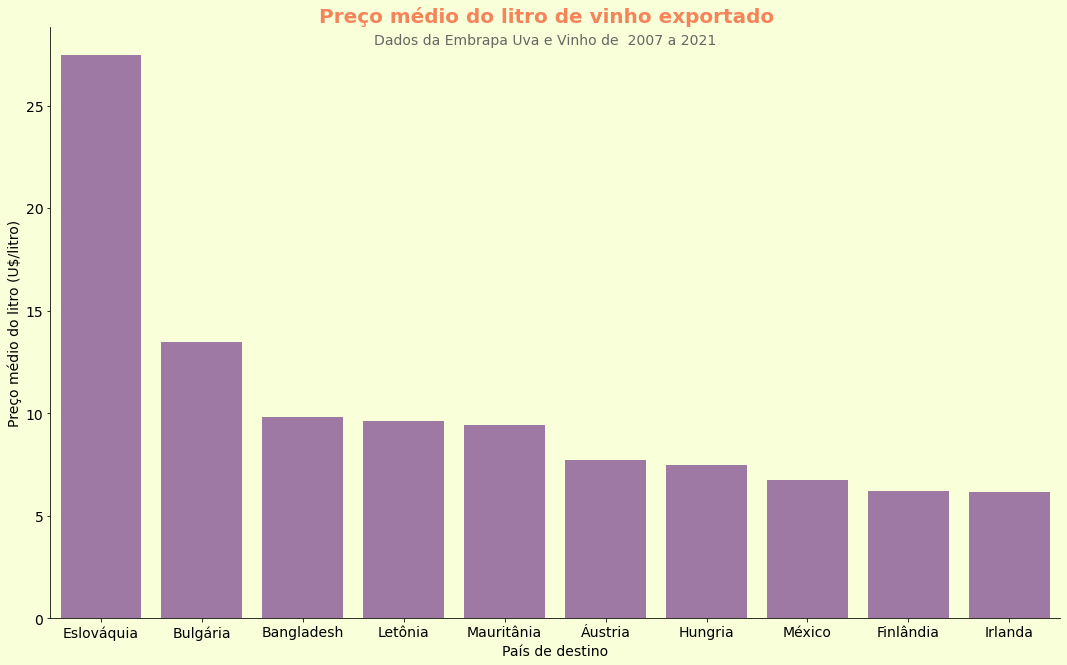

In [28]:
# Escolhe o tema/estilo do gráfico dentre os já criados na pasta Estilos
plt.style.use('./Assets/Estilos/barras.mplstyle')

# Cria um sobplot par a figura
fig, ax = plt.subplots(figsize=(15,9), facecolor='#F8FFD9')

# Escolhe o layout tight para o gráfico
plt.tight_layout()

fig.suptitle('Preço médio do litro de vinho exportado', size=20, weight='semibold', x=.5, y=1, color="#F5845B", ha='center', va='top',fontname='Liberation Serif')
plt.text(x=4.4, y=28, s='Dados da Embrapa Uva e Vinho de  2007 a 2021', fontsize=14, alpha=0.85, color="#4d4d4d", ha='center')

ax = sns.barplot(data=wine_data_temperature.sort_values(by='preco_litro', ascending=False).iloc[:10, :], x='pais_destino', y='preco_litro', color='#A272AB')

ax.set_xlabel('País de destino')
ax.set_ylabel('Preço médio do litro (U$/litro)')

# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')
# Altera a cor fora do gráfico
fig.patch.set_facecolor('#F8FFD9')

plt.show()

filename = 'barplot_preco_medio_litro_vinho'
fig.savefig('./results/'+filename+'.png', bbox_inches='tight')

É possível perceber que entre os maiores valores de preço médio do litro de vinho, estão países pouco relevantes na quantidade de vinho exportada. Pode ser um indicativo de países para estreitar relações comerciais no futuro e ter vendas mais rentáveis.

Nesse sentido, é interessante observar como o preço do litro e o valor total de exportação se relacionam, pois o ideal é aliar grandes quantidades de vinho a um preço médio por litro elevado.

In [38]:
# Adição de labels em pontos específicos do gráfico
wine_data_temperature_filtered = wine_data_temperature.iloc[:17, :]
labels = wine_data_temperature_filtered.pais_destino
x_labels = wine_data_temperature_filtered.preco_litro
y_labels = wine_data_temperature_filtered.litros_exportados

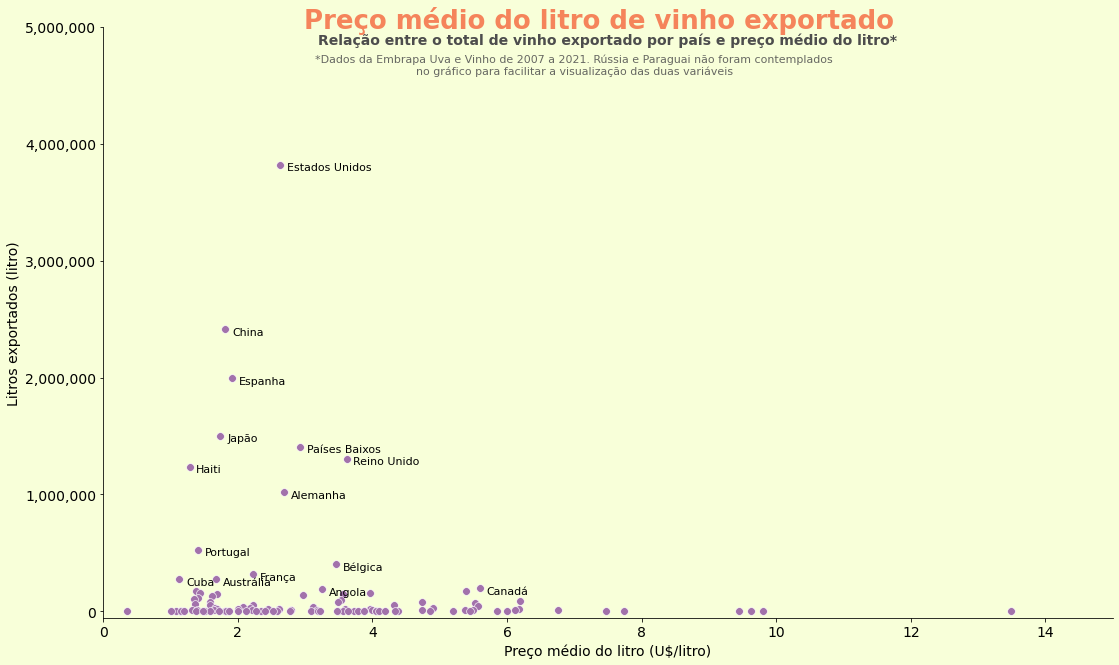

In [41]:
# Escolhe o tema/estilo do gráfico dentre os já criados na pasta Estilos
plt.style.use('./Assets/Estilos/barras.mplstyle')

# Cria um sobplot para a figura
fig, ax = plt.subplots(figsize=(15,9), facecolor='#F8FFD9')

# Escolhe o layout tight para o gráfico
plt.tight_layout()

ax = sns.scatterplot(data=wine_data_temperature, x='preco_litro', y='litros_exportados', color='#A272AB', s=60)

# Configuração dos eixos
ax.set_xlim(0, 15)
ax.set_ylim(-60000, 5000000)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.set_xlabel('Preço médio do litro (U$/litro)')
ax.set_ylabel('Litros exportados (litro)')

# Annotate label points 
for i, label in enumerate (labels):
    plt.annotate(label, (x_labels[i]+0.1, y_labels[i]-50000), fontsize=11)

fig.suptitle('Preço médio do litro de vinho exportado', size=26, weight='semibold', x=.5, y=1, color="#F5845B", ha='center', va='top',fontname='Liberation Serif')
plt.text(x=7.5, y=4850000, s='Relação entre o total de vinho exportado por país e preço médio do litro*', fontsize=14, color="#4d4d4d", ha='center', weight='semibold')
plt.text(x=7, y=4700000, s='*Dados da Embrapa Uva e Vinho de 2007 a 2021. Rússia e Paraguai não foram contemplados', fontsize=11, alpha=0.85, color="#4d4d4d", ha='center')
plt.text(x=7, y=4600000, s='no gráfico para facilitar a visualização das duas variáveis', fontsize=11, alpha=0.85, color="#4d4d4d", ha='center')

# Altera a cor dentro do gráfico
ax.set_facecolor('#F8FFD9')
# Altera a cor fora do gráfico
fig.patch.set_facecolor('#F8FFD9')

plt.show()

filename = 'scatterplot_litros_exportados_preco_medio'
fig.savefig('./results/'+filename+'.png', bbox_inches='tight')

Através desse gráfico, é possível ter mais indícios sobre a tendência das váriáveis preço médio do litro e total de litros exportados serem inversamente proporcionais, pelo motivo de que a comercialização de grandes quantidades do produto tendem a baratear o custo do litro.

Entretanto, vemos algumas exceções como os EUA, Países Baixos e Reino Unido, que possuem grande volume de compra e um preço médio do litro mais elevado quando comparados aos outros países que compararam quantidades parecidas de vinho brasileiro. Portanto são considerados mercados muito interessantes para o Brasil estreitar relações e expandir as exportações.

Outro fator determinante na relação dessas duas variáveis pode ter um viés economico, pois verifica-se que os maiores preços médios do litro de vinho correspondem a países desenvolvidos economicamente, principalmente do continente europeu. Uma das intepretações possíveis é que tais países têm maior poder de compra e por isso o Brasil consegue praticar um preço mais vantajoso nas negociações, por outro lado isso também pode indicar que são mercados mais exigentes e compram apenas os vinhos de maior qualidade.

## Litros exportados x Temperatura média

In [42]:
wine_data_temperature

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro
0,Brasil,Rússia,RUS,39230153,25559026,-5.35,0.65
1,Brasil,Paraguai,PRY,25423559,32364257,23.55,1.27
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55,2.63
3,Brasil,China,CHN,2411701,4372268,7.50,1.81
4,Brasil,Espanha,ESP,1993000,3808552,13.30,1.91
...,...,...,...,...,...,...,...
119,Brasil,Senegal,SEN,0,0,27.85,NaN
120,Brasil,Jamaica,JAM,0,0,24.95,NaN
121,Brasil,Anguilla,NaN,0,0,26.00,NaN
122,Brasil,Costa do Marfim,CIV,0,0,26.35,NaN


In [43]:
# Adição de labels em pontos específicos do gráfico
wine_data_temperature_filtered = wine_data_temperature_milhoes.iloc[:17, :]
labels = wine_data_temperature_filtered.pais_destino
x_labels = wine_data_temperature_filtered.temp_anual_media
y_labels = wine_data_temperature_filtered.litros_exportados

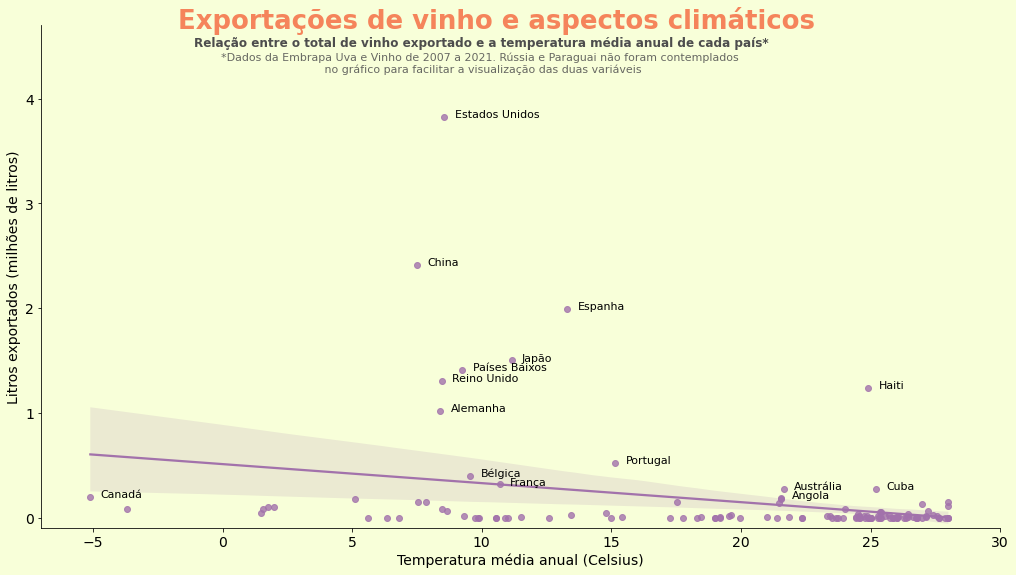

In [44]:
# Escolhe o tema/estilo do gráfico dentre os já criados na pasta Estilos
plt.style.use('./Assets/Estilos/barras.mplstyle')

fig = sns.lmplot(data=wine_data_temperature_milhoes.iloc[2:,:], x='temp_anual_media', y='litros_exportados', height=8, aspect=1.8, scatter_kws={'color':'#A272AB'},line_kws={'color':'#A272AB'})

# Escolhe o layout tight para o gráfico
plt.tight_layout()

fig.set(ylim=(-0.1, 4.7))
fig.set(xlim=(-7, 30))

fig.axes[0][0].yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

fig.axes[0][0].set_xlabel('Temperatura média anual (Celsius)')
fig.axes[0][0].set_ylabel('Litros exportados (milhões de litros)')

fig.fig.suptitle('Exportações de vinho e aspectos climáticos', size=26, weight='semibold', x=.5, y=1, color="#F5845B", ha='center', va='top',fontname='Liberation Serif')
plt.text(x=10, y=4.5, s='Relação entre o total de vinho exportado e a temperatura média anual de cada país*', fontsize=12, color="#4d4d4d", ha='center', weight='semibold')
plt.text(x=10, y=4.25, s='*Dados da Embrapa Uva e Vinho de 2007 a 2021. Rússia e Paraguai não foram contemplados \n no gráfico para facilitar a visualização das duas variáveis', fontsize=11, alpha=0.85, color="#4d4d4d", ha='center')
#plt.text(x=7, y=4600000, s='no gráfico para facilitar a visualização das duas variáveis', fontsize=11, alpha=0.85, color="#4d4d4d", ha='center')

# Annotate label points 
for i, label in enumerate (labels):
    plt.annotate(label, (x_labels[i]+0.4, y_labels[i]-0.005), fontsize=11)

# Altera a cor dentro do gráfico
fig.axes[0][0].set_facecolor('#F8FFD9')
# Altera a cor fora do gráfico
fig.fig.patch.set_facecolor('#F8FFD9')

plt.show()

filename = 'lmplot_litros_exportados_temperatura_media'
fig.savefig('./results/'+filename+'.png', bbox_inches='tight')

## Temp média e população

In [46]:
population_data = pd.read_csv('./data/processed/populacao_mundial.csv')
population_data = population_data[['País (ou território dependente)', 'Estimativa da ONU', 'Data', 'Estimativa Oficial']]
population_data

,País (ou território dependente),Estimativa da ONU,Data,Estimativa Oficial
0,Índia,1 429 921 746,2023,Estimativa oficial
1,China,1 426 391 281,2023,Censo oficial
2,Estados Unidos,339 987 103,2023,Censo oficial
3,Indonésia,277 184 719,2023,Estimativa oficial
4,Paquistão,240 215 932,2023,Estimativa oficial
...,...,...,...,...
245,Ilha de Ascensão (Reino Unido),806,2021,Estimativa oficial[10]
246,Vaticano,801,2020,Estimativa oficial
247,Ilhas Cocos (Keeling) (Austrália),573,2020,Estimativa oficial
248,Tristão da Cunha (Reino Unido),241,2022,Estimativa oficial[11]


In [56]:
population_list_countries_to_correct = [country for country in population_data['País (ou território dependente)'].unique() if country not in wine_data_temperature.pais_destino.unique()]
print(len(population_list_countries_to_correct))
print(population_list_countries_to_correct)

151
['Paquistão', 'Etiópia', 'Egito', 'Vietname', 'República Democrática do Congo', 'Myanmar', 'Quénia', 'Coreia do Sul', 'Uganda', 'Argélia', 'Sudão', 'Ucrânia', 'Polónia', 'Marrocos', 'Arábia Saudita', 'Uzbequistão', 'Moçambique', 'Iémen', 'Nepal', 'Madagascar', 'Coreia do Norte', 'Níger', 'Sri Lanka', 'Burquina Fasso', 'Mali', 'Roménia', 'Malawi', 'Cazaquistão', 'Zâmbia', 'Síria', 'Camboja', 'Chade', 'Somália', 'Zimbabwe', 'Guiné', 'Ruanda', 'Burundi', 'Sudão do Sul', 'Chéquia', 'Azerbaijão', 'Tajiquistão', 'Bielorrússia', 'Papua-Nova Guiné', 'Israel', 'Hong Kong (China)', 'Laos', 'Sérvia', 'Líbia', 'Quirguistão', 'Turquemenistão', 'Omã', 'Palestina', 'República Centro-Africana', 'Kuwait', 'Geórgia', 'Eritreia', 'Bósnia e Herzegovina', 'Mongólia', 'Arménia', 'Albânia', 'Porto Rico (Estados Unidos)', 'Lituânia', 'Moldávia', 'Gâmbia', 'Botswana', 'Gabão', 'Lesoto', 'Macedônia do Norte', 'Eslovénia', 'Letónia', 'Kosovo', 'Bahrein', 'Estónia', 'Timor-Leste', 'Maurícia', 'Eswatini', 'Dji

Vemos que há alguns nomes desnecessários entre parênteses, indicando à que país pertence determinados territórios autônomos. Vamos retirar essa informação

In [64]:
new_populacion_country_names = [country.split('(')[0] for country in population_data['País (ou território dependente)']]
new_populacion_country_names = [country.strip() for country in new_populacion_country_names]
print(new_populacion_country_names)

population_data['pais'] = new_populacion_country_names
population_data

['Índia', 'China', 'Estados Unidos', 'Indonésia', 'Paquistão', 'Nigéria', 'Brasil', 'Bangladesh', 'Rússia', 'México', 'Etiópia', 'Japão', 'Filipinas', 'Egito', 'Vietname', 'República Democrática do Congo', 'Turquia', 'Irã', 'Alemanha', 'Tailândia', 'Reino Unido', 'França', 'Itália', 'Tanzânia', 'África do Sul', 'Myanmar', 'Quénia', 'Coreia do Sul', 'Colômbia', 'Espanha', 'Uganda', 'Argentina', 'Argélia', 'Sudão', 'Ucrânia', 'Iraque', 'Afeganistão', 'Polónia', 'Canadá', 'Marrocos', 'Arábia Saudita', 'Uzbequistão', 'Peru', 'Angola', 'Malásia', 'Moçambique', 'Gana', 'Iémen', 'Nepal', 'Venezuela', 'Madagascar', 'Camarões', 'Costa do Marfim', 'Coreia do Norte', 'Austrália', 'Níger', 'Taiwan', 'Sri Lanka', 'Burquina Fasso', 'Mali', 'Roménia', 'Malawi', 'Chile', 'Cazaquistão', 'Zâmbia', 'Guatemala', 'Equador', 'Síria', 'Países Baixos', 'Senegal', 'Camboja', 'Chade', 'Somália', 'Zimbabwe', 'Guiné', 'Ruanda', 'Benim', 'Burundi', 'Tunísia', 'Bolívia', 'Bélgica', 'Haiti', 'Cuba', 'Sudão do Sul', 

,País (ou território dependente),Estimativa da ONU,Data,Estimativa Oficial,pais
0,Índia,1 429 921 746,2023,Estimativa oficial,Índia
1,China,1 426 391 281,2023,Censo oficial,China
2,Estados Unidos,339 987 103,2023,Censo oficial,Estados Unidos
3,Indonésia,277 184 719,2023,Estimativa oficial,Indonésia
4,Paquistão,240 215 932,2023,Estimativa oficial,Paquistão
...,...,...,...,...,...
245,Ilha de Ascensão (Reino Unido),806,2021,Estimativa oficial[10],Ilha de Ascensão
246,Vaticano,801,2020,Estimativa oficial,Vaticano
247,Ilhas Cocos (Keeling) (Austrália),573,2020,Estimativa oficial,Ilhas Cocos
248,Tristão da Cunha (Reino Unido),241,2022,Estimativa oficial[11],Tristão da Cunha


In [67]:
wine_data_temperature_population = wine_data_temperature.merge(population_data[['pais', 'Estimativa da ONU']], left_on='pais_destino', right_on='pais', how='left')
wine_data_temperature_population.loc[wine_data_temperature_population['Estimativa da ONU'].isna()]

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro,pais,Estimativa da ONU
20,Brasil,Polônia,POL,154475,611080,7.85,3.96,NaN,NaN
21,Brasil,República Tcheca,CZE,150527,536018,7.55,3.56,NaN,NaN
22,Brasil,Curaçao,CUW,150446,253733,28.00,1.69,NaN,NaN
25,Brasil,Antilhas Holandesas,NaN,114027,160864,28.00,1.41,NaN,NaN
26,Brasil,Estônia,EST,107768,144886,2.00,1.34,NaN,NaN
43,Brasil,"Marshall, Ilhas",MHL,23113,60422,27.40,2.61,NaN,NaN
47,Brasil,Quênia,KEN,17471,45547,24.75,2.61,NaN,NaN
58,Brasil,Vietnã,VNM,9669,12736,24.45,1.32,NaN,NaN
65,Brasil,Coréia do Sul,KOR,4900,19872,11.50,4.06,NaN,NaN
75,Brasil,Barein,BHR,792,3066,26.80,3.87,NaN,NaN


Alguns nomes de países serão corrigidos

In [71]:
population_list_countries_to_correct = ['Polónia', 'Chéquia', 'Curaçau','Estónia','Ilhas Marshall','Quénia','Vietname', 'Coreia do Sul','Bahrein','Letónia','Bósnia e Herzegovina']

new_populacion_country_names = ['Polônia','República Tcheca','Curaçao','Estônia','Marshall, Ilhas','Quênia','Vietnã','Coréia do Sul','Barein','Letônia','Bósnia-Herzegovina']

# Criação de  dicionário para mudança dos nomes
dict_rename_paises_population = dict(zip(population_list_countries_to_correct, new_populacion_country_names))
dict_rename_paises_population

{'Polónia': 'Polônia',
 'Chéquia': 'República Tcheca',
 'Curaçau': 'Curaçao',
 'Estónia': 'Estônia',
 'Ilhas Marshall': 'Marshall, Ilhas',
 'Quénia': 'Quênia',
 'Vietname': 'Vietnã',
 'Coreia do Sul': 'Coréia do Sul',
 'Bahrein': 'Barein',
 'Letónia': 'Letônia',
 'Bósnia e Herzegovina': 'Bósnia-Herzegovina'}

In [94]:
population_data_renamed = population_data.replace({'pais':dict_rename_paises_population})

In [95]:
wine_data_temperature_population = wine_data_temperature.merge(population_data_renamed[['pais', 'Estimativa da ONU']], left_on='pais_destino', right_on='pais', how='left')
wine_data_temperature_population

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro,pais,Estimativa da ONU
0,Brasil,Rússia,RUS,39230153,25559026,-5.35,0.65,Rússia,148 221 749
1,Brasil,Paraguai,PRY,25423559,32364257,23.55,1.27,Paraguai,7 132 538
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55,2.63,Estados Unidos,339 987 103
3,Brasil,China,CHN,2411701,4372268,7.50,1.81,China,1 426 391 281
4,Brasil,Espanha,ESP,1993000,3808552,13.30,1.91,Espanha,46 754 778
...,...,...,...,...,...,...,...,...,...
119,Brasil,Senegal,SEN,0,0,27.85,NaN,Senegal,16 743 927
120,Brasil,Jamaica,JAM,0,0,24.95,NaN,Jamaica,2 961 167
121,Brasil,Anguilla,NaN,0,0,26.00,NaN,NaN,NaN
122,Brasil,Costa do Marfim,CIV,0,0,26.35,NaN,Costa do Marfim,26 378 274


In [96]:
# Coluna de população está como texto
print(wine_data_temperature_population.dtypes)

pais_origem           object
pais_destino          object
iso_cod               object
litros_exportados      int64
valor_exportacao       int64
temp_anual_media     float64
preco_litro          float64
pais                  object
Estimativa da ONU     object
dtype: object


In [98]:
# Os espaços precisam ser retirados
wine_data_temperature_population['Estimativa da ONU'].values[0]

'148 221 749'

In [99]:
wine_data_temperature_population['Estimativa da ONU'] = wine_data_temperature_population['Estimativa da ONU'].str.replace(' ','')
wine_data_temperature_population

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro,pais,Estimativa da ONU
0,Brasil,Rússia,RUS,39230153,25559026,-5.35,0.65,Rússia,148221749
1,Brasil,Paraguai,PRY,25423559,32364257,23.55,1.27,Paraguai,7132538
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55,2.63,Estados Unidos,339987103
3,Brasil,China,CHN,2411701,4372268,7.50,1.81,China,1426391281
4,Brasil,Espanha,ESP,1993000,3808552,13.30,1.91,Espanha,46754778
...,...,...,...,...,...,...,...,...,...
119,Brasil,Senegal,SEN,0,0,27.85,NaN,Senegal,16743927
120,Brasil,Jamaica,JAM,0,0,24.95,NaN,Jamaica,2961167
121,Brasil,Anguilla,NaN,0,0,26.00,NaN,NaN,NaN
122,Brasil,Costa do Marfim,CIV,0,0,26.35,NaN,Costa do Marfim,26378274


In [109]:
wine_data_temperature_population['Estimativa da ONU'] = wine_data_temperature_population['Estimativa da ONU'].fillna(0)
wine_data_temperature_population['Estimativa da ONU'] = wine_data_temperature_population['Estimativa da ONU'].astype(int)
wine_data_temperature_population

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro,pais,Estimativa da ONU
0,Brasil,Rússia,RUS,39230153,25559026,-5.35,0.65,Rússia,148221749
1,Brasil,Paraguai,PRY,25423559,32364257,23.55,1.27,Paraguai,7132538
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55,2.63,Estados Unidos,339987103
3,Brasil,China,CHN,2411701,4372268,7.50,1.81,China,1426391281
4,Brasil,Espanha,ESP,1993000,3808552,13.30,1.91,Espanha,46754778
...,...,...,...,...,...,...,...,...,...
119,Brasil,Senegal,SEN,0,0,27.85,NaN,Senegal,16743927
120,Brasil,Jamaica,JAM,0,0,24.95,NaN,Jamaica,2961167
121,Brasil,Anguilla,NaN,0,0,26.00,NaN,NaN,15094
122,Brasil,Costa do Marfim,CIV,0,0,26.35,NaN,Costa do Marfim,26378274


Por fim, será adicionado manualmente os valores de população faltantes

In [110]:
wine_data_temperature_population.loc[wine_data_temperature_population['Estimativa da ONU'] == 0]

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro,pais,Estimativa da ONU


In [111]:
# Criação de lista com nome dos países sem dado de população
list_countries_no_population = list(wine_data_temperature_population.loc[wine_data_temperature_population['Estimativa da ONU'] == 0].pais_destino)

# Lista com valores de temperatura anual média obtida na web via ChatGPT
list_populations = [227049, 72412, 1192000, 105870, 15094]

# Criação de  dicionário para atualizar os valores de temperatura
dict_add_population_values = dict(zip(list_countries_no_population, list_populations))
print(dict_add_population_values)

{}


In [112]:
wine_data_temperature_population.loc[wine_data_temperature_population['pais_destino'].isin(dict_add_population_values.keys()), 'Estimativa da ONU'] = wine_data_temperature_population['pais_destino'].map(dict_add_population_values)

print('Total de países com valor de população nulo:', len(wine_data_temperature_population.loc[wine_data_temperature_population['Estimativa da ONU'] == 0]))
display(wine_data_temperature_population)

Total de países com valor de população nulo: 0


,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,temp_anual_media,preco_litro,pais,Estimativa da ONU
0,Brasil,Rússia,RUS,39230153,25559026,-5.35,0.65,Rússia,148221749
1,Brasil,Paraguai,PRY,25423559,32364257,23.55,1.27,Paraguai,7132538
2,Brasil,Estados Unidos,USA,3822251,10046712,8.55,2.63,Estados Unidos,339987103
3,Brasil,China,CHN,2411701,4372268,7.50,1.81,China,1426391281
4,Brasil,Espanha,ESP,1993000,3808552,13.30,1.91,Espanha,46754778
...,...,...,...,...,...,...,...,...,...
119,Brasil,Senegal,SEN,0,0,27.85,NaN,Senegal,16743927
120,Brasil,Jamaica,JAM,0,0,24.95,NaN,Jamaica,2961167
121,Brasil,Anguilla,NaN,0,0,26.00,NaN,NaN,15094
122,Brasil,Costa do Marfim,CIV,0,0,26.35,NaN,Costa do Marfim,26378274


Renomeando e selecionando colunas

In [113]:
wine_data_temperature_population.rename(columns={'Estimativa da ONU':'populacao'}, inplace=True)
wine_data_temperature_population = wine_data_temperature_population[['pais_origem','pais_destino','iso_cod','litros_exportados','valor_exportacao','preco_litro','populacao','temp_anual_media']]
wine_data_temperature_population

,pais_origem,pais_destino,iso_cod,litros_exportados,valor_exportacao,preco_litro,populacao,temp_anual_media
0,Brasil,Rússia,RUS,39230153,25559026,0.65,148221749,-5.35
1,Brasil,Paraguai,PRY,25423559,32364257,1.27,7132538,23.55
2,Brasil,Estados Unidos,USA,3822251,10046712,2.63,339987103,8.55
3,Brasil,China,CHN,2411701,4372268,1.81,1426391281,7.50
4,Brasil,Espanha,ESP,1993000,3808552,1.91,46754778,13.30
...,...,...,...,...,...,...,...,...
119,Brasil,Senegal,SEN,0,0,NaN,16743927,27.85
120,Brasil,Jamaica,JAM,0,0,NaN,2961167,24.95
121,Brasil,Anguilla,NaN,0,0,NaN,15094,26.00
122,Brasil,Costa do Marfim,CIV,0,0,NaN,26378274,26.35


In [114]:
# Exportando novos dataframes
wine_data_temperature_population.to_csv('./data/processed/wine_data_15_years.csv', index=False)

wine_data_temperature_population_milions = wine_data_temperature_population.copy()
wine_data_temperature_population_milions[['litros_exportados','valor_exportacao']] = wine_data_temperature_population_milions[['litros_exportados','valor_exportacao']]/1_000_000
wine_data_temperature_population_milions.to_csv('./data/processed/wine_data_15_years_millions.csv.csv', index=False)
